In [1]:
import numpy as np
import tensorflow as tf
import cv2 as cv
import matplotlib.pyplot as plt
import time

In [2]:
model = tf.lite.Interpreter('posenet_mobilenet_v1_100_257x257_multi_kpt_stripped1.tflite')
model.allocate_tensors()
input_details = model.get_input_details()
output_details = model.get_output_details()

In [3]:
img = cv.imread('zly.jpeg')
input_img = tf.reshape(tf.image.resize(img, [257,257]), [1,257,257,3])
floating_model = input_details[0]['dtype'] == np.float32
if floating_model:
    input_img = (np.float32(input_img) - 127.5) / 127.5
model.set_tensor(input_details[0]['index'], input_img)
start = time.time()
model.invoke()
print('time:',time.time()-start)
output_data =  model.get_tensor(output_details[0]['index'])
offset_data = model.get_tensor(output_details[1]['index'])
heatmaps = np.squeeze(output_data)
offsets = np.squeeze(offset_data)
print("output shape: {}".format(output_data.shape))

time: 0.07382607460021973
output shape: (1, 9, 9, 17)


In [4]:
show_img = np.squeeze((input_img.copy()*127.5+127.5)/255.0)[:,:,::-1]
show_img = np.array(show_img*255,np.uint8)

(-0.5, 256.5, 256.5, -0.5)

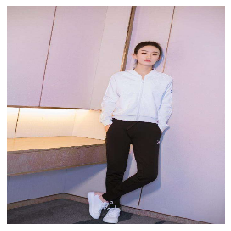

In [5]:
plt.imshow(show_img)
plt.axis('off')

## 所有关节

In [6]:
def parse_output(heatmap_data,offset_data):
    joint_num = heatmap_data.shape[-1]
    pose_kps = np.zeros((joint_num,2),np.int32)
    for i in range(heatmap_data.shape[-1]):
        joint_heatmap = heatmap_data[...,i]
        max_val_pos = np.squeeze(np.argwhere(joint_heatmap==np.max(joint_heatmap)))
        remap_pos = np.array(max_val_pos/8*257,dtype=np.int32)
        pose_kps[i,0] = int(remap_pos[0] + offset_data[max_val_pos[0],max_val_pos[1],i])
        pose_kps[i,1] = int(remap_pos[1] + offset_data[max_val_pos[0],max_val_pos[1],i+joint_num])
    return pose_kps

In [7]:
def draw_kps(show_img,kps,point_size=2,color=(0,255,0)):
    for i in range(kps.shape[0]):
        cv.circle(show_img,(kps[i,1],kps[i,0]),point_size,color,-1)
    return show_img

In [8]:
kps = parse_output(heatmaps,offsets)

(-0.5, 256.5, 256.5, -0.5)

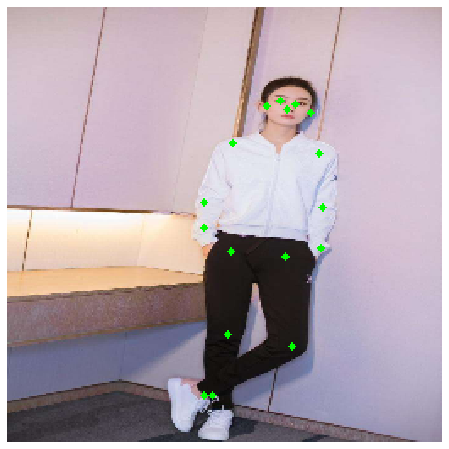

In [9]:
plt.figure(figsize=(8,8))
plt.imshow(draw_kps(show_img.copy(),kps))
plt.axis('off')

## 映射回原图

In [10]:
ratio_x = img.shape[0]/257.0
ratio_y = img.shape[1]/257.0
def remap_joint(pose_kps):   
    joint_num = pose_kps.shape[0]
    remap_pos = np.zeros((joint_num,2),np.int32)
    for i in range(joint_num):      
        remap_pos[i,0]=pose_kps[i,0]*ratio_x
        remap_pos[i,1]=pose_kps[i,1]*ratio_y
    return remap_pos

(-0.5, 689.5, 1034.5, -0.5)

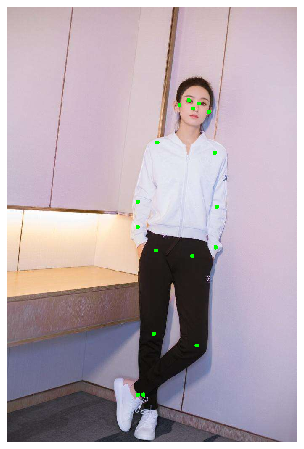

In [11]:
remap_kps = remap_joint(kps)
plt.figure(figsize=(8,8))
plt.imshow(draw_kps(img[:,:,::-1].copy(),remap_kps,5,(0,255,0)))
plt.axis('off')

## 测试单个关节

In [12]:
i=1
joint_heatmap = heatmaps[...,i]

In [13]:
max_val_pos = np.squeeze(np.argwhere(joint_heatmap==np.max(joint_heatmap)))
remap_pos = np.array(max_val_pos/8*257,dtype=np.int32)

refine_pos = np.zeros((2),dtype=int)
refine_pos[0] = int(remap_pos[0] + offsets[max_val_pos[0],max_val_pos[1],i])
refine_pos[1] = int(remap_pos[1] + offsets[max_val_pos[0],max_val_pos[1],i+heatmaps.shape[-1]])

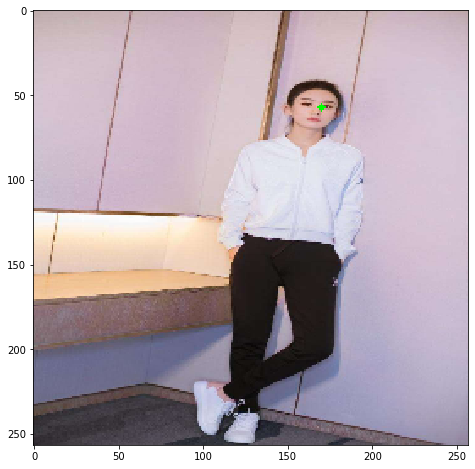

In [14]:
show_img = np.squeeze((input_img.copy()*127.5+127.5)/255.0)[:,:,::-1]
show_img = np.array(show_img*255,np.uint8)
plt.figure(figsize=(8,8))
plt.imshow(cv.circle(show_img,(refine_pos[1],refine_pos[0]),2,(0,255,0),-1))

## 看看得分

In [15]:
def get_score(one_heatmap):
    scores = 1/(1 + np.exp(-one_heatmap))
    return np.max(scores)

In [16]:
for i in range(heatmaps.shape[-1]):
    one_joint = heatmaps[...,i]
    print(get_score(one_joint))

0.9993794
0.9906837
0.99678123
0.7773388
0.889261
0.9936773
0.9942778
0.98862654
0.95809233
0.9498602
0.97852063
0.98825955
0.9573086
0.966709
0.9768833
0.91263163
0.87949383


## 将关键点重新映射到原图

In [17]:
ratio_x = img.shape[0]/257
ratio_y = img.shape[1]/257
refine_pos[0]=refine_pos[0]*ratio_x
refine_pos[1]=refine_pos[1]*ratio_y

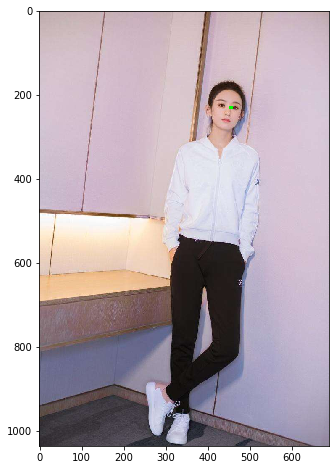

In [18]:
show_img1 = img[:,:,::-1]
plt.figure(figsize=(8,8))
plt.imshow(cv.circle(show_img1.copy(),(refine_pos[1],refine_pos[0]),5,(0,255,0),-1))